In [1]:
import sys
sys.path.extend(['/home/quic/QUIC-Projects'])

import json
import dill

import logging
from pathlib import Path

import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from tqdm.notebook import tqdm
from itertools import product

with open('./result/sampling_fixed_ds/setting.json', 'r') as f:
    ALPHA_SETTING = json.load(fp=f)
with open('./result/trial5/setting.json', 'r') as f:
    PQC_SETTING = json.load(fp=f)

def total_variance_distance(P, Q):
    return 0.5*sum(np.abs(P-Q))

def sample_alpha():
    alpha_dir = Path(ALPHA_SETTING["BASE_DIR"])
    alpha_list = []
    for si in tqdm(list(range(2*ALPHA_SETTING["NUM_ALPHA_SAMPLE"])), desc='Alpha_Sampling'):
        with open(alpha_dir / f"Dataset #{si}" / "result.json", 'r') as _f:
            _result = json.load(_f)
        _alpha = np.array(_result['alpha'])
        alpha_list.append(_alpha)
    return alpha_list

def sample_pqc():
    pqc_dir = Path(PQC_SETTING["BASE_DIR"])
    pqc_list = {}
    for si, ci, l in tqdm(list(product(range(PQC_SETTING["NUM_SETS"]),PQC_SETTING["CIRCUIT_ID"],PQC_SETTING["LAYERS"])), desc='PQC_Sampling'):
        pqc_list[(ci, l)] = []
        for r in range(PQC_SETTING["REPEATS"]):
            with open(pqc_dir / f"Dataset #{si}/Circuit #{ci}/layer={l}/{r}/nqsvm", 'rb') as _nqsvm_file:
                _nqsvm = dill.load(_nqsvm_file)
            _var_form = _nqsvm.var_form
            _params = _nqsvm.parameters
            _sv = Statevector(_var_form.assign_parameters(dict(zip(_var_form.parameters, _params))))
            pqc_list[(ci, l)].append(_sv.probabilities())
    return pqc_list


def random_sample_pqc():
    pqc_dir = Path(PQC_SETTING["BASE_DIR"])
    pqc_list = {}
    for si, ci, l in tqdm(list(product(range(PQC_SETTING["NUM_SETS"]),PQC_SETTING["CIRCUIT_ID"],PQC_SETTING["LAYERS"])), desc='random_PQC_Sampling'):
        pqc_list[(ci, l)] = []
        for r in range(PQC_SETTING["REPEATS"]):
            with open(pqc_dir / f"Dataset #{si}/Circuit #{ci}/layer={l}/{r}/nqsvm", 'rb') as _nqsvm_file:
                _nqsvm = dill.load(_nqsvm_file)
            _var_form = _nqsvm.var_form
            _params = 2*np.pi*np.random.rand(_nqsvm.num_parameters)
            _sv = Statevector(_var_form.assign_parameters(dict(zip(_var_form.parameters, _params))))
            pqc_list[(ci, l)].append(_sv.probabilities())
    return pqc_list

In [2]:
alpha_list = sample_alpha()
pqc_list = sample_pqc()
random_pqc_list = random_sample_pqc()

Alpha_Sampling:   0%|          | 0/1024 [00:00<?, ?it/s]

PQC_Sampling:   0%|          | 0/152 [00:00<?, ?it/s]

random_PQC_Sampling:   0%|          | 0/152 [00:00<?, ?it/s]

In [3]:
from classifiers.convex.svm import BinarySVM
from classifiers.datasets import IrisDataset
from qiskit_machine_learning.kernels import QuantumKernel
with open('./result/trial5/Dataset #0/Circuit #4/layer=8/0/nqsvm', 'rb') as __F:
    nqsvm = dill.load(__F)
feature_map = nqsvm.feature_map
quantum_instance = nqsvm.quantum_instance
X = np.load('./result/trial5/Dataset #0/X.npy')
y = np.load('./result/trial5/Dataset #0/y.npy')
ds = IrisDataset(feature_range=(-np.pi, np.pi), true_hot=0)
Xt = ds.data
yt = ds.target
my_qk = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance, enforce_psd=False)
def my_kernel_function(x1, x2):
    return (np.abs(my_qk.evaluate([x1], [x2])) ** 2).item()
svm = BinarySVM(kernel=my_kernel_function, C=None, mutation='REDUCED_QASVM', k=1)
svm.fit(X, y)
solution_alpha = svm.alpha


In [4]:
def sample_distance(pqc_id, pqc_layer, seeds=None):
    if seeds is None:
        alpha = alpha_list[np.random.choice(len(alpha_list), 1).item()]
        beta = pqc_list[(pqc_id, pqc_layer)][np.random.choice(8, 1).item()]
    else:
        # alpha = alpha_list[seeds[0]]
        alpha = solution_alpha
        beta = pqc_list[(pqc_id, pqc_layer)][seeds[1]]
    return total_variance_distance(alpha, beta)

def random_sample_distance(pqc_id, pqc_layer, seeds=None):
    if seeds is None:
        alpha = alpha_list[np.random.choice(len(alpha_list), 1).item()]
        beta = random_pqc_list[(pqc_id, pqc_layer)][np.random.choice(8, 1).item()]
    else:
        # alpha = alpha_list[seeds[0]]
        alpha = solution_alpha
        beta = random_pqc_list[(pqc_id, pqc_layer)][seeds[1]]
    return total_variance_distance(alpha, beta)

In [60]:
from pandas import read_csv
expr_ref = read_csv('./result/trial5/result.csv')

def get_circuit_expr(cid, l):
    return expr_ref[(expr_ref['circuit_id']==cid) & (expr_ref['layer']==l)]["('expr', 'mean')"].item()

def get_circuit_num_params(cid, l):
    return expr_ref[(expr_ref['circuit_id']==cid) & (expr_ref['layer']==l)]["num_params"].item()

In [68]:
expr_ref.columns

Index(['Unnamed: 0', 'dataset', 'circuit_id', 'layer', 'num_params',
       'dataset.1', '('accuracy', 'mean')', '('accuracy', 'median')',
       '('accuracy', 'std')', '('entcap', 'mean')', '('expr', 'mean')',
       '('last_cost_avg', 'mean')', '('last_cost_avg', 'median')',
       '('last_cost_avg', 'std')', '('num_iter', 'mean')',
       '('num_iter', 'median')', '('num_iter', 'std')'],
      dtype='object')

In [62]:
from itertools import product
from pandas import DataFrame, concat
from tqdm.notebook import tqdm
from classifiers.quantum.ansatz import PQC_Properties, sample_circuit
tmp = []
for si, ci, l in tqdm(list(product(range(PQC_SETTING["NUM_SETS"]), PQC_SETTING["CIRCUIT_ID"], PQC_SETTING["LAYERS"]))):
    for a, b in zip(np.random.choice(len(alpha_list), 2**10), np.random.choice(8, 2**10)):
        tmp.append(DataFrame({'circuit_id':ci,
                              'layer':l,
                              'distance':sample_distance(ci, l, (a, b)),
                              'random_distance':random_sample_distance(ci, l, (a, b)),
                              'expr':get_circuit_expr(ci, l),
                              'num_params':get_circuit_num_params(ci, l)},
                             index=[0]))

  0%|          | 0/152 [00:00<?, ?it/s]

In [63]:
result = concat(tmp, ignore_index=True)
data = result.pivot_table(values=['distance', 'random_distance', 'expr'], index=['circuit_id', 'layer', 'num_params'])
d1 = np.array(list(data.index))
d2 = data.to_numpy()
result2 = DataFrame(data=np.hstack([d1, d2]), columns=list(data.index.names) + list(data.columns))


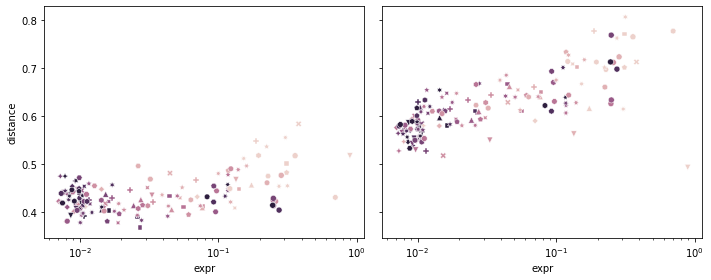

In [64]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
sns.scatterplot(ax=axes[0], data=result2, x='expr', y='distance', hue='layer', style='circuit_id')
axes[0].set_xscale('log')
sns.scatterplot(ax=axes[1], data=result2, x='expr', y='random_distance', hue='layer', style='circuit_id')
axes[1].set_xscale('log')
axes[0].get_legend().remove()
axes[1].get_legend().remove()
plt.tight_layout()

In [66]:
result2

,circuit_id,layer,num_params,distance,expr,random_distance
0,1.0,1.0,10.0,0.517500,0.358838,0.764633
1,1.0,2.0,20.0,0.476629,0.285003,0.722952
2,1.0,3.0,30.0,0.422606,0.259123,0.711337
3,1.0,4.0,40.0,0.425425,0.248860,0.625843
4,1.0,5.0,50.0,0.413646,0.250510,0.633302
...,...,...,...,...,...,...
147,19.0,4.0,60.0,0.437195,0.011185,0.553180
148,19.0,5.0,75.0,0.381314,0.008121,0.580880
149,19.0,6.0,90.0,0.403891,0.009570,0.549620
150,19.0,7.0,105.0,0.439085,0.007348,0.579047


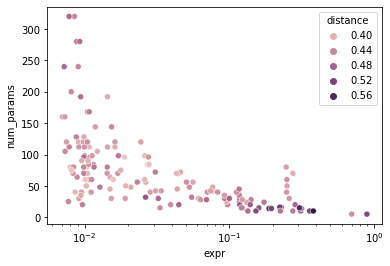

In [65]:
sns.scatterplot(data=result2, x='expr', y='num_params', hue='distance')
plt.xscale('log')

In [16]:
from sklearn.svm import SVC
with open('./result/sampling_fixed_ds/Dataset #0/nqsvm', 'rb') as f:
    nqsvm = dill.load(f)
kernel = nqsvm.kernel_matrix
X = nqsvm.data
y = nqsvm.label

In [19]:
svm = SVC(C=10000, kernel='precomputed')

In [20]:
svm.fit(kernel, y)

SVC(C=10000, kernel='precomputed')

In [23]:
from classifiers.datasets import IrisDataset
from qiskit_machine_learning.kernels import QuantumKernel
ds = IrisDataset(feature_range=(-np.pi, np.pi), true_hot=0)
Xt = ds.data
yt = ds.target
qk = QuantumKernel(feature_map=nqsvm.feature_map, quantum_instance=nqsvm.quantum_instance, enforce_psd=False)
test_kernel = np.abs(qk.evaluate(Xt, X)) ** 2
svm.predict(test_kernel)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [25]:
sum(yt==svm.predict(test_kernel))/len(yt)

0.9266666666666666

In [26]:
nqsvm.accuracy(Xt, yt)


0.9333333333333333

In [27]:
sum(y==svm.predict(kernel))/len(y)

1.0

In [28]:
nqsvm.accuracy(X, y)

1.0

In [50]:
def main():
    pqc_dir = Path(PQC_SETTING["BASE_DIR"])
    f_list = {}
    acc_list = {}
    for si, ci, l in tqdm(list(product(range(PQC_SETTING["NUM_SETS"]),PQC_SETTING["CIRCUIT_ID"],PQC_SETTING["LAYERS"])), desc='PQC_Sampling'):
        f_list[(ci, l)] = []
        for r in range(PQC_SETTING["REPEATS"]):
            with open(pqc_dir / f"Dataset #{si}/Circuit #{ci}/layer={l}/{r}/full_result.json", 'r') as _file:
                _result = json.load(_file)
            _f = np.array(_result['f'])
            f_list[(ci, l)].append(_f)
        _acc = sum(np.where(sum(f_list[(ci, l)])>0, 1, 0)==yt)/len(yt)
        acc_list[(ci, l)] = _acc
    return f_list, acc_list

In [51]:
f_list, acc_list = main()

PQC_Sampling:   0%|          | 0/152 [00:00<?, ?it/s]

In [52]:
df_list = []
for (ci, l), acc in acc_list.items():
    df_list.append(DataFrame({'circuit_id':ci, 'layer':l, 'accuracy':acc, 'expr':get_circuit_expr(ci, l)}, index=[0]))
data = concat(df_list, ignore_index=True)

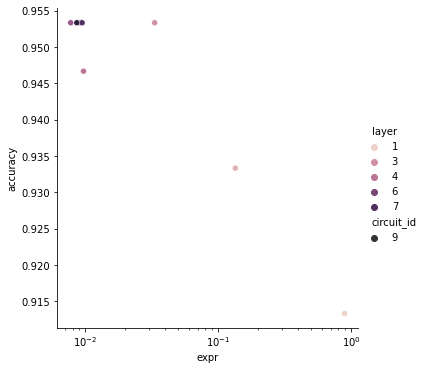

In [53]:
sns.relplot(
    data=data.loc[data['circuit_id']==9],
    x='expr', y='accuracy', hue='layer', style='circuit_id')
plt.xscale('log')

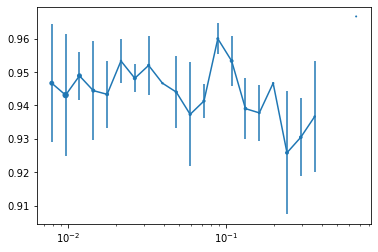

In [46]:
min_expr = min(data['expr'])
max_expr = max(data['expr'])
edges = np.logspace(np.log10(min_expr), np.log10(max_expr), num=25)

expr=[]
acc=[]
acc_std = []
num = []
for i in range(len(edges)-1):
    _data = data.loc[(data['expr']>=edges[i]) & (data['expr']<edges[i+1])]['accuracy']
    expr.append(edges[i]/2+edges[i+1]/2)
    acc.append(np.mean(_data))
    acc_std.append(np.std(_data))
    num.append(len(_data))


plt.errorbar(expr, acc, yerr=acc_std)
plt.scatter(expr, acc, s=num)
plt.xscale('log')

In [69]:
from classifiers.convex.svm import BinarySVM

my_qk = QuantumKernel(feature_map=nqsvm.feature_map, quantum_instance=nqsvm.quantum_instance, enforce_psd=False)
def my_kernel_function(x1, x2):
    return (np.abs(my_qk.evaluate([x1], [x2])) ** 2).item()

In [74]:
my_svm1 = BinarySVM(kernel=my_kernel_function, C=None, mutation='REDUCED_QASVM', k=1)
my_svm1.fit(X, y)
my_svm2 = BinarySVM(kernel=my_kernel_function, C=None, mutation='REDUCED_QASVM', k=1)
my_svm2.fit(X, y)

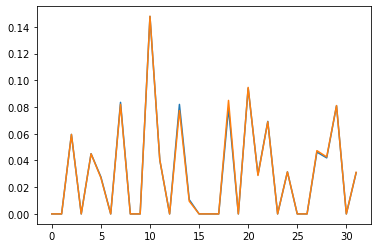

In [75]:
plt.plot(my_svm1.alpha)
plt.plot(my_svm2.alpha)

In [76]:
my_alpha = my_svm1.alpha

In [77]:
sum(my_alpha)


1.0000000000000002

In [23]:
min_dist = result2.min()['distance']
result3 = result2.loc[result2['distance']<=min_dist+0.02]

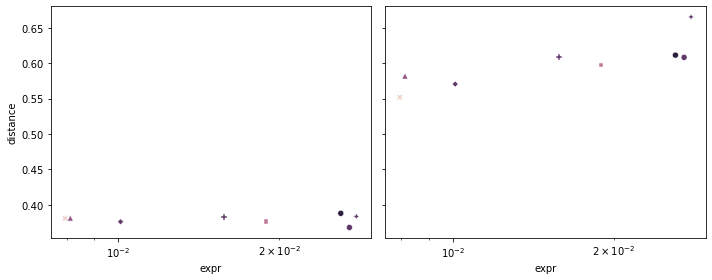

In [24]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
sns.scatterplot(ax=axes[0], data=result3, x='expr', y='distance', hue='layer', style='circuit_id')
axes[0].set_xscale('log')
sns.scatterplot(ax=axes[1], data=result3, x='expr', y='random_distance', hue='layer', style='circuit_id')
axes[1].set_xscale('log')
axes[0].get_legend().remove()
axes[1].get_legend().remove()
plt.tight_layout()

In [26]:
result2.loc[result2['distance']<=min_dist]

,circuit_id,layer,distance,expr,random_distance
21,3.0,6.0,0.368059,0.0271,0.608145


In [40]:
from classifiers.quantum.qasvm import NormQSVM, QuantumInstance
from classifiers.quantum.ansatz import sample_circuit
var_form = sample_circuit(3)(5, reps=6)
_tmp_c = sample_circuit(9)(4, reps=1)
feature_map = _tmp_c.compose(_tmp_c)
qasvm = NormQSVM(X, y, quantum_instance=quantum_instance, var_form=var_form, feature_map=feature_map)

In [41]:
from classifiers.optimizer import tSPSA

Normalized QSVM(84 number of params)

In [58]:
data.loc[data['accuracy']==data.max()['accuracy']]

,circuit_id,layer,accuracy,expr
10,2,3,0.966667,0.015306
26,4,3,0.966667,0.033896
75,10,4,0.966667,0.117721
111,14,8,0.966667,0.008410
112,15,1,0.966667,0.700359
117,15,6,0.966667,0.092819
135,17,8,0.966667,0.009141
